# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from random import shuffle
import random

In [2]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Define constants & methods

In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "version_name = " + "'"+attribs['data-notebook-name'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
version_name = version_name.split('.')[0]

In [5]:
save_model_path = "/home/chamodi17/Documents/fyp/notebooks/MobileNet/output/"+version_name
save_history_path = "/home/chamodi17/Documents/fyp/notebooks/MobileNet/output/"+version_name

In [6]:
save_history_path

'/home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v13-k-cross'

In [7]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [8]:
# plot graphs for training and valdation data
def plot_graphs(history):
  acc = [0.] + history.history['accuracy']
  val_acc = [0.] + history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc,'o-g', label='Training Accuracy')
  plt.plot(val_acc, 'o-r',label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, 'o-g', label='Training Loss')
  plt.plot(val_loss, 'o-r',label='Validation Loss',color='red')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,3.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [9]:
# get accuray of test data
def getModelAccuracy(dataframe):
    sample_test = dataframe
    correctPredictions = 0

    correctNormalPred = 0
    correctCovidPred = 0
    correctPneumoniaPred = 0

    totalNormalPred = 0
    totalCovidPred = 0
    totalPneumoniaPred = 0

    for index, row in sample_test.iterrows():

        filename = row['filename']
        prediction = row['category']

        # img = load_img(path + 'CrossValidationDataset\\' + filename, target_size=IMAGE_SIZE)

        if (path +'/normal') in filename:

            if prediction == 0:
                correctPredictions += 1
                correctNormalPred += 1

            totalNormalPred += 1

        if (path + '/covid') in filename:

            if prediction == 1: 
                correctPredictions += 1
                correctCovidPred += 1

            totalCovidPred += 1

        if (path + '/pneumonia') in filename:

            if prediction == 2: 
                correctPredictions += 1
                correctPneumoniaPred += 1

            totalPneumoniaPred += 1
            
    print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
    print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

    print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
    print('Covid Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
    print('Pneumonia Predictions:', correctPneumoniaPred, 'Accuracy', "{:.2%}".format(correctPneumoniaPred / totalPneumoniaPred))
    
    return (correctPredictions / test_df.shape[0]) * 100

In [10]:
# plot confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools

# np_config.enable_numpy_behavior()
    
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    # thresh = np.max(cm) / 1.5 if normalize else np.max(cm) / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    



In [11]:
path = "/home/sch17/Documents/fyp/dataset"

# Create dataframe

In [12]:
directories = ['/normal']
categories = []
filenames = []
    
files = os.listdir(path + directories[0])

for img in files:
    categories.append(0)
    filenames.append(path+directories[0]+"/"+img)

files.sort()
df_NORMAL = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

print(df_NORMAL.shape[0])
df_NORMAL.head()

directories = ['/pneumonia']
categories = []
filenames = []
    
files = os.listdir(path + directories[0])

for img in files:
    categories.append(2)
    filenames.append(path+directories[0]+"/"+img)

files.sort()
df_PNEUMONIA = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

print(df_PNEUMONIA.shape[0])
df_PNEUMONIA.head()

directories = ['/covid']
categories = []
filenames = []
    
files = os.listdir(path + directories[0])

for img in files:
    categories.append(1)
    filenames.append(path+directories[0]+"/"+img)

files.sort()
df_COVID = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

print(df_COVID.shape[0])
df_COVID.head()


1583
4273
3616


,filename,category
0,/home/sch17/Documents/fyp/dataset/covid/COVID-...,1
1,/home/sch17/Documents/fyp/dataset/covid/COVID-...,1
2,/home/sch17/Documents/fyp/dataset/covid/COVID-...,1
3,/home/sch17/Documents/fyp/dataset/covid/COVID-...,1
4,/home/sch17/Documents/fyp/dataset/covid/COVID-...,1


In [13]:
pd.options.display.max_colwidth = 100

In [14]:
df = pd.concat([df_NORMAL, df_PNEUMONIA, df_COVID])


In [15]:
# shuffle data
df = df.sample(frac=1).reset_index(drop = True)
df

,filename,category
0,/home/sch17/Documents/fyp/dataset/covid/COVID-701.png,1
1,/home/sch17/Documents/fyp/dataset/pneumonia/person801_virus_1434.jpeg,2
2,/home/sch17/Documents/fyp/dataset/normal/NORMAL2-IM-0369-0001.jpeg,0
3,/home/sch17/Documents/fyp/dataset/pneumonia/person1363_bacteria_3483.jpeg,2
4,/home/sch17/Documents/fyp/dataset/covid/COVID-2879.png,1
...,...,...
9467,/home/sch17/Documents/fyp/dataset/covid/COVID-2163.png,1
9468,/home/sch17/Documents/fyp/dataset/pneumonia/person1267_bacteria_3226.jpeg,2
9469,/home/sch17/Documents/fyp/dataset/normal/IM-0444-0001.jpeg,0
9470,/home/sch17/Documents/fyp/dataset/covid/COVID-2498.png,1


<AxesSubplot:>

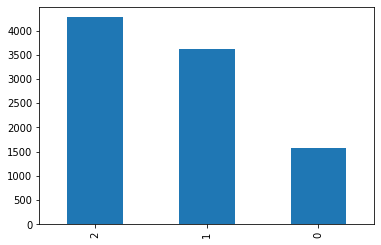

In [17]:
df['category'].value_counts().plot.bar()

train/val/test split - 60% | 20% | 20%

# Model






Transfer Learning

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


In [19]:
base_model.trainable = False

In [20]:
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(0.2)(x)
x= tfl.Dense(64, activation='relu')(x) #64 units
x= tfl.Dense(256, activation='relu')(x) #256 units
outputs = tfl.Dense(3, activation='softmax')(x) # 3 units
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771   

# K cross

Found 5682 validated image filenames belonging to 3 classes.
Found 1895 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
178/178 [==============================] - 107s 588ms/step - loss: 0.4642 - accuracy: 0.8333 - val_loss: 0.2015 - val_accuracy: 0.9335
Epoch 2/10
178/178 [==============================] - 103s 577ms/step - loss: 0.1745 - accuracy: 0.9377 - val_loss: 0.1411 - val_accuracy: 0.9493
Epoch 3/10
178/178 [==============================] - 103s 579ms/step - loss: 0.1439 - accuracy: 0.9481 - val_loss: 0.1162 - val_accuracy: 0.9583
Epoch 4/10
178/178 [==============================] - 103s 580ms/step - loss: 0.1358 - accuracy: 0.9486 - val_loss: 0.1196 - val_accuracy: 0.9520
Epoch 5/10
178/178 [==============================] - 104s 582ms/step - loss: 0.1202 - accuracy: 0.9541 - val_loss: 0.1002 - val_accuracy: 0.9668
Epoch 6/10
178/178 [==============================]

/home/chamodi17/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/40
178/178 [==============================] - 105s 590ms/step - loss: 0.1790 - accuracy: 0.9395 - val_loss: 0.1199 - val_accuracy: 0.9504

Epoch 00011: val_loss improved from 0.21127 to 0.11989, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v13-k-cross_1.h5
Epoch 12/40
178/178 [==============================] - 105s 586ms/step - loss: 0.1262 - accuracy: 0.9511 - val_loss: 0.3180 - val_accuracy: 0.9082

Epoch 00012: val_loss did not improve from 0.11989
Epoch 13/40
178/178 [==============================] - 105s 587ms/step - loss: 0.1180 - accuracy: 0.9585 - val_loss: 0.0856 - val_accuracy: 0.9668

Epoch 00013: val_loss improved from 0.11989 to 0.08564, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v13-k-cross_1.h5
Epoch 14/40
178/178 [==============================] - 105s 586ms/step - loss: 0.1056 - accuracy: 0.9639 - val_loss: 0.0679 - val_accuracy: 0.9726

Epoch 00014: val_loss

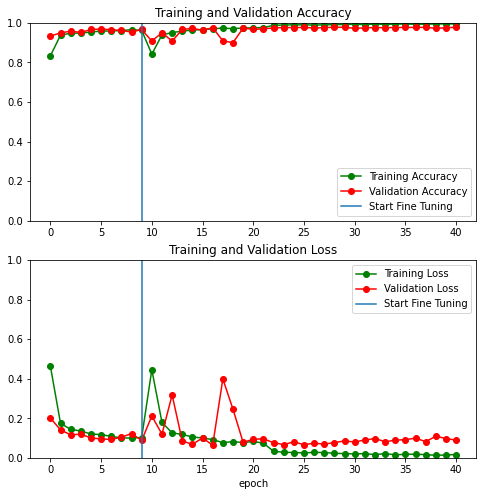

Found 1895 validated image filenames.
Model Accuracy: 98.10%
Correct Predictions: 1859 Total Predictions: 1895

Normal Predictions: 306 Accuracy 96.23%
Covid Predictions: 705 Accuracy 99.58%
Pneumonia Predictions: 848 Accuracy 97.58%


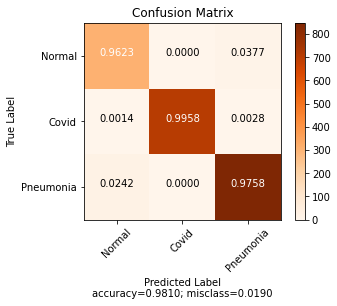

              precision    recall  f1-score   support

      Normal       0.93      0.96      0.95       318
       Covid       1.00      1.00      1.00       708
   Pneumonia       0.98      0.98      0.98       869

    accuracy                           0.98      1895
   macro avg       0.97      0.98      0.98      1895
weighted avg       0.98      0.98      0.98      1895

Precision: 0.9722285099881162
Recall: 0.9779537183659306
F1 : 0.9750085841722389
[[306   0  12]
 [  1 705   2]
 [ 21   0 848]]
Found 5682 validated image filenames belonging to 3 classes.
Found 1895 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/10
178/178 [==============================] - 107s 590ms/step - loss: 0.4750 - accuracy: 0.8358 - val_loss: 0.1949 - val_accuracy: 0.9340
Epoch 2/10
178/178 [==============================] - 104s 583ms/step - loss: 0.1725 - accuracy: 0.9403 - val_loss: 0.1427 - va

/home/chamodi17/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/40
178/178 [==============================] - 105s 591ms/step - loss: 0.1731 - accuracy: 0.9379 - val_loss: 0.1331 - val_accuracy: 0.9588

Epoch 00011: val_loss improved from 0.37274 to 0.13309, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v13-k-cross_2.h5
Epoch 12/40
178/178 [==============================] - 106s 592ms/step - loss: 0.1386 - accuracy: 0.9518 - val_loss: 0.1357 - val_accuracy: 0.9515

Epoch 00012: val_loss did not improve from 0.13309
Epoch 13/40
178/178 [==============================] - 105s 591ms/step - loss: 0.1208 - accuracy: 0.9600 - val_loss: 0.1008 - val_accuracy: 0.9646

Epoch 00013: val_loss improved from 0.13309 to 0.10076, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v13-k-cross_2.h5
Epoch 14/40
178/178 [==============================] - 105s 590ms/step - loss: 0.1127 - accuracy: 0.9644 - val_loss: 0.0782 - val_accuracy: 0.9752

Epoch 00014: val_loss

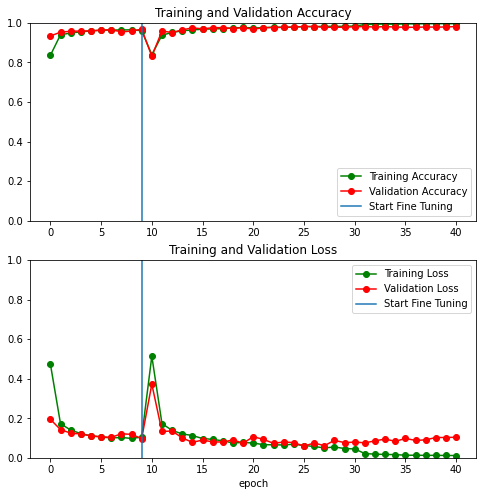

Found 1895 validated image filenames.
Model Accuracy: 97.36%
Correct Predictions: 1845 Total Predictions: 1895

Normal Predictions: 307 Accuracy 92.75%
Covid Predictions: 690 Accuracy 99.57%
Pneumonia Predictions: 848 Accuracy 97.36%


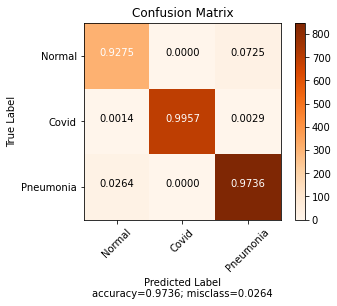

              precision    recall  f1-score   support

      Normal       0.93      0.93      0.93       331
       Covid       1.00      1.00      1.00       693
   Pneumonia       0.97      0.97      0.97       871

    accuracy                           0.97      1895
   macro avg       0.97      0.97      0.97      1895
weighted avg       0.97      0.97      0.97      1895

Precision: 0.965914721125683
Recall: 0.9655856711364669
F1 : 0.9657476735021951
[[307   0  24]
 [  1 690   2]
 [ 23   0 848]]
Found 5683 validated image filenames belonging to 3 classes.
Found 1895 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/10
178/178 [==============================] - 107s 590ms/step - loss: 0.4679 - accuracy: 0.8313 - val_loss: 0.1852 - val_accuracy: 0.9398
Epoch 2/10
178/178 [==============================] - 104s 583ms/step - loss: 0.1781 - accuracy: 0.9351 - val_loss: 0.1370 - val

/home/chamodi17/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/40
178/178 [==============================] - 106s 594ms/step - loss: 0.1958 - accuracy: 0.9324 - val_loss: 0.0992 - val_accuracy: 0.9689

Epoch 00011: val_loss improved from 1.32978 to 0.09921, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v13-k-cross_3.h5
Epoch 12/40
178/178 [==============================] - 106s 592ms/step - loss: 0.1499 - accuracy: 0.9509 - val_loss: 0.2503 - val_accuracy: 0.9018

Epoch 00012: val_loss did not improve from 0.09921
Epoch 13/40
178/178 [==============================] - 105s 591ms/step - loss: 0.1263 - accuracy: 0.9558 - val_loss: 0.0736 - val_accuracy: 0.9736

Epoch 00013: val_loss improved from 0.09921 to 0.07362, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v13-k-cross_3.h5
Epoch 14/40
178/178 [==============================] - 106s 594ms/step - loss: 0.1136 - accuracy: 0.9606 - val_loss: 0.0934 - val_accuracy: 0.9784

Epoch 00014: val_loss

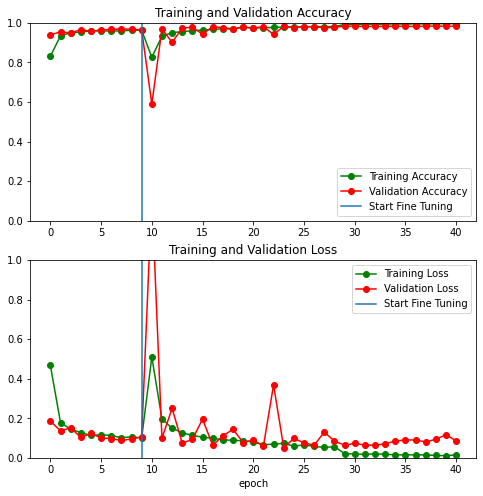

Found 1894 validated image filenames.
Model Accuracy: 97.99%
Correct Predictions: 1856 Total Predictions: 1894

Normal Predictions: 278 Accuracy 93.29%
Covid Predictions: 730 Accuracy 99.59%
Pneumonia Predictions: 848 Accuracy 98.26%


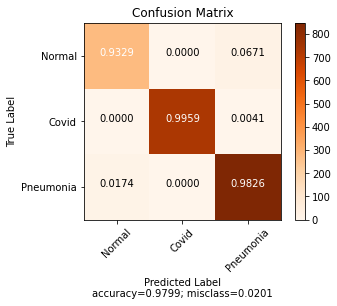

              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94       298
       Covid       1.00      1.00      1.00       733
   Pneumonia       0.97      0.98      0.98       863

    accuracy                           0.98      1894
   macro avg       0.97      0.97      0.97      1894
weighted avg       0.98      0.98      0.98      1894

Precision: 0.9741330104531164
Recall: 0.9704706361087162
F1 : 0.9722710375277982
[[278   0  20]
 [  0 730   3]
 [ 15   0 848]]
Found 5683 validated image filenames belonging to 3 classes.
Found 1895 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/10
178/178 [==============================] - 107s 588ms/step - loss: 0.4227 - accuracy: 0.8573 - val_loss: 0.2054 - val_accuracy: 0.9340
Epoch 2/10
178/178 [==============================] - 104s 581ms/step - loss: 0.1671 - accuracy: 0.9414 - val_loss: 0.1396 - va

/home/chamodi17/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/40
178/178 [==============================] - 106s 593ms/step - loss: 0.1705 - accuracy: 0.9451 - val_loss: 0.1713 - val_accuracy: 0.9340

Epoch 00011: val_loss improved from 0.26979 to 0.17131, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v13-k-cross_4.h5
Epoch 12/40
178/178 [==============================] - 105s 590ms/step - loss: 0.1558 - accuracy: 0.9525 - val_loss: 0.1151 - val_accuracy: 0.9530

Epoch 00012: val_loss improved from 0.17131 to 0.11507, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v13-k-cross_4.h5
Epoch 13/40
178/178 [==============================] - 105s 591ms/step - loss: 0.1159 - accuracy: 0.9592 - val_loss: 0.0914 - val_accuracy: 0.9662

Epoch 00013: val_loss improved from 0.11507 to 0.09139, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v13-k-cross_4.h5
Epoch 14/40
178/178 [==============================]

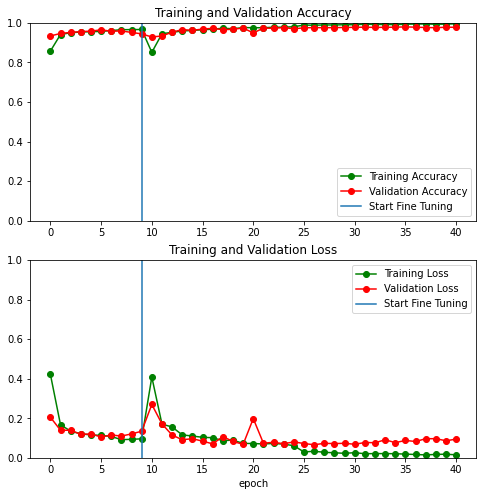

Found 1894 validated image filenames.
Model Accuracy: 98.20%
Correct Predictions: 1860 Total Predictions: 1894

Normal Predictions: 292 Accuracy 93.29%
Covid Predictions: 726 Accuracy 99.32%
Pneumonia Predictions: 842 Accuracy 99.06%


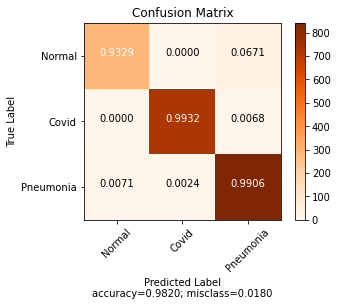

              precision    recall  f1-score   support

      Normal       0.98      0.93      0.96       313
       Covid       1.00      0.99      1.00       731
   Pneumonia       0.97      0.99      0.98       850

    accuracy                           0.98      1894
   macro avg       0.98      0.97      0.98      1894
weighted avg       0.98      0.98      0.98      1894

Precision: 0.9823882006713789
Recall: 0.9722185460854972
F1 : 0.9770739621887605
[[292   0  21]
 [  0 726   5]
 [  6   2 842]]
Found 5683 validated image filenames belonging to 3 classes.
Found 1895 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/10
178/178 [==============================] - 106s 580ms/step - loss: 0.4765 - accuracy: 0.8334 - val_loss: 0.1972 - val_accuracy: 0.9330
Epoch 2/10
178/178 [==============================] - 103s 576ms/step - loss: 0.1741 - accuracy: 0.9370 - val_loss: 0.1467 - va

/home/chamodi17/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/40
178/178 [==============================] - 106s 592ms/step - loss: 0.1930 - accuracy: 0.9354 - val_loss: 0.1281 - val_accuracy: 0.9520

Epoch 00011: val_loss improved from 0.15273 to 0.12809, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v13-k-cross_5.h5
Epoch 12/40
178/178 [==============================] - 105s 589ms/step - loss: 0.1488 - accuracy: 0.9511 - val_loss: 0.5301 - val_accuracy: 0.8359

Epoch 00012: val_loss did not improve from 0.12809
Epoch 13/40
178/178 [==============================] - 105s 586ms/step - loss: 0.1277 - accuracy: 0.9565 - val_loss: 0.1183 - val_accuracy: 0.9625

Epoch 00013: val_loss improved from 0.12809 to 0.11831, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v13-k-cross_5.h5
Epoch 14/40
178/178 [==============================] - 105s 587ms/step - loss: 0.1035 - accuracy: 0.9660 - val_loss: 0.0851 - val_accuracy: 0.9731

Epoch 00014: val_loss

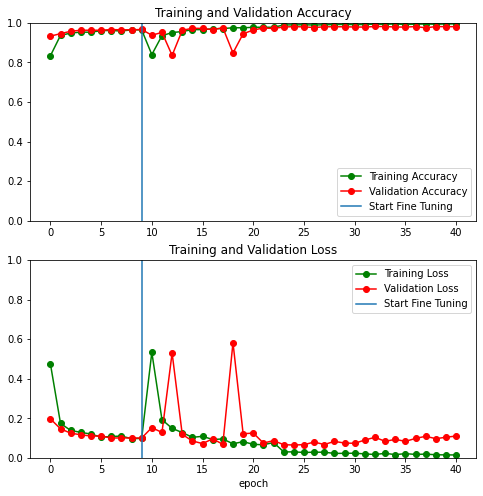

Found 1894 validated image filenames.
Model Accuracy: 97.78%
Correct Predictions: 1852 Total Predictions: 1894

Normal Predictions: 312 Accuracy 96.59%
Covid Predictions: 746 Accuracy 99.33%
Pneumonia Predictions: 794 Accuracy 96.83%


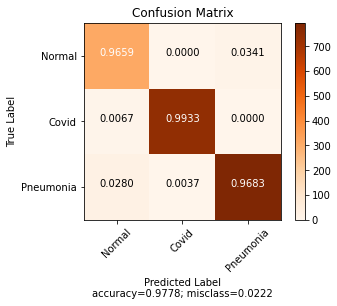

              precision    recall  f1-score   support

      Normal       0.92      0.97      0.94       323
       Covid       1.00      0.99      0.99       751
   Pneumonia       0.99      0.97      0.98       820

    accuracy                           0.98      1894
   macro avg       0.97      0.98      0.97      1894
weighted avg       0.98      0.98      0.98      1894

Precision: 0.9666590406987662
Recall: 0.9758597219196005
F1 : 0.9710246354952238
[[312   0  11]
 [  5 746   0]
 [ 23   3 794]]
[98.10026385224275, 97.36147757255937, 97.9936642027455, 98.20485744456178, 97.78247096092925]
average accuracy =  97.88854680660772
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
______________

In [22]:
from sklearn.model_selection import KFold

fold_no = 1
batch_size = 32
initial_epochs = 10
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

acc_per_fold = []
perf_per_fold = []

inputs = df['filename']
targets = df['category']

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

for train, test in kfold.split(inputs, targets):
  tf.keras.backend.clear_session()
  base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
  base_model.trainable = False
  input_tensor = tf.keras.Input(shape=input_shape)
  x = base_model(input_tensor, training=False)
  x = tfl.GlobalAveragePooling2D()(x)
  x = tfl.Dropout(0.2)(x)
  x= tfl.Dense(64, activation='relu')(x) #64 units
  x= tfl.Dense(256, activation='relu')(x) #256 units
  outputs = tfl.Dense(3, activation='softmax')(x) # 3 units
  model = tf.keras.Model(input_tensor, outputs)

  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate= 0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
  
  ##Separate Training Data
  categories = []
  
  for img in inputs[train]:

      fileName = img.split('.')[0]

      if '/normal' in fileName: categories.append(0)
      elif '/covid' in fileName: categories.append(1)
      else: categories.append(2)

  cross_val_df = pd.DataFrame ({
      'filename': inputs[train],
      'category': categories
  })

  cross_val_df["category"] = cross_val_df["category"].replace({0: 'Normal', 1: 'Covid', 2:'Pneumonia'})
    
  train_df, validate_df = train_test_split(cross_val_df, test_size=0.25)
  train_df = train_df.reset_index(drop=True)
  validate_df = validate_df.reset_index(drop=True)

  train_generator = ImageDataGenerator(
      rescale=1./127.5,
      width_shift_range = 0.1,
      height_shift_range = 0.1
      ).flow_from_dataframe (
        train_df, 
        x_col = 'filename',
        y_col = 'category',
        target_size = IMAGE_SIZE,
        class_mode = 'categorical',
        batch_size = batch_size
    )
  
  validation_generator = ImageDataGenerator(rescale=1./127.5).flow_from_dataframe (
        validate_df, 
        x_col ='filename',
        y_col = 'category',
        target_size = IMAGE_SIZE,
        class_mode = 'categorical',
        batch_size = batch_size
    )
  
  
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  model_checkpoint = ModelCheckpoint(save_model_path + '_' + str(fold_no) +".h5", save_best_only=True, verbose=1)
  reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

  history = model.fit(train_generator,
                    validation_data=validation_generator, 
                    epochs=initial_epochs,
                    batch_size=batch_size)
  
  base_model.trainable = True
  # Fine-tune from this layer onwards
  fine_tune_at = 100

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate= 0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
  
  history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator,
                         batch_size=batch_size,
                         callbacks=[model_checkpoint, reduce_lr])

  
  model.save(save_model_path + '_' + str(fold_no) +".h5") # save path

  ## plot graph
  # plot_graphs(history)
  acc = history.history['accuracy'] + history_fine.history['accuracy']
  val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

  loss = history.history['loss'] + history_fine.history['loss']
  val_loss = history.history['val_loss'] + history_fine.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, 'o-g', label='Training Accuracy')
  plt.plot(val_acc, 'o-r', label='Validation Accuracy')
  plt.ylim([0, 1])
  plt.plot([initial_epochs-1,initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, 'o-g', label='Training Loss')
  plt.plot(val_loss, 'o-r', label='Validation Loss')
  plt.ylim([0, 1.0])
  plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

  ##Separate Testing Data
  test_filenames = []
    
  for img in inputs[test]:

      test_filenames.append(img)
      
  test_df = pd.DataFrame({
      'filename': test_filenames
  })
  
  nb_samples = test_df.shape[0]

  test_generator = ImageDataGenerator(rescale = 1./127.5).flow_from_dataframe(
      test_df, 
      x_col = 'filename',
      y_col = None,
      class_mode = None,
      target_size = IMAGE_SIZE,
      batch_size = batch_size,
      shuffle = False
  )

  #Get Test Data Predictions 
  predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

  # print("predict================================================================")
  # print(predict)
  # print("done================================================================")

  test_df['category'] = np.argmax(predict, axis=-1)
  label_map = dict((v,k) for k,v in train_generator.class_indices.items())
  test_df['category'] = test_df['category'].replace(label_map)
  test_df['category'] = test_df['category'].replace({'Normal': 0, 'Covid': 1, 'Pneumonia': 2})

  actual = []
  pred = []

  for row in test_df.iterrows():

      filename = row[1][0]

      if '/normal' in filename: actual.append(0)
      if '/covid' in filename: actual.append(1)
      if '/pneumonia' in filename: actual.append(2)
      pred.append(row[1][1])


  fold_no = fold_no + 1

  # Get performance metrics  
  accuracy = getModelAccuracy(test_df)
  acc_per_fold.append(accuracy)
  perf_per_fold.append([actual, pred])

  cf = confusion_matrix(actual, pred)

  # print("##############################printing cf#################################")
  # print(cf)
  # print(type(cf))
  # print("##############################done#################################")

    
  target_names = ['Normal','Covid', 'Pneumonia']
  plot_confusion_matrix(cf, target_names)

  print(classification_report(actual, pred, target_names=target_names))

  # calculate precision
  precision = precision_score(actual, pred,  average='macro')
  print('Precision:', precision)

  # calculate recall
  recall = recall_score(actual, pred,  average='macro')
  print('Recall:', recall)

  # f1
  # f1 =  2 * (precision * recall) / (precision + recall)
  f1 = f1_score(actual, pred,  average='macro')
  print ("F1 :", f1)

  print(confusion_matrix(actual, pred))
print(acc_per_fold)
print("average accuracy = ",sum(acc_per_fold)/5)
model.summary()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,865,283
Non-trainable params: 396,544
_________________________________________________________________


# Saved model


In [ ]:
loaded_model = tf.keras.models.load_model(save_model_path)











































































































# predict

In [ ]:
pre_test_df = test_df

In [ ]:
batch_size = 32
nb_samples = test_df.shape[0]

In [ ]:
test_generator = ImageDataGenerator(rescale = 1./127.5).flow_from_dataframe(
    test_df, 
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 1895 validated image filenames.


In [ ]:
predict = loaded_model.predict(test_generator_eval, steps = np.ceil(nb_samples/batch_size))


In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
sample_test = test_df.head(18)
sample_test.head()

,filename,category
0,/content/pauldataset/covid/COVID-568.png,0
1,/content/pauldataset/pneumonia/person501_bacteria_2115.jpeg,2
2,/content/pauldataset/covid/COVID-21.png,0
3,/content/pauldataset/covid/COVID-2836.png,0
4,/content/pauldataset/pneumonia/person838_virus_1476.jpeg,2


In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({'Normal': 0, 'Covid': 1, 'Pneumonia': 2})

In [ ]:
test_df

,filename,category
0,/content/pauldataset/covid/COVID-568.png,1
1,/content/pauldataset/pneumonia/person501_bacteria_2115.jpeg,2
2,/content/pauldataset/covid/COVID-21.png,1
3,/content/pauldataset/covid/COVID-2836.png,1
4,/content/pauldataset/pneumonia/person838_virus_1476.jpeg,2
...,...,...
1890,/content/pauldataset/pneumonia/person475_bacteria_2022.jpeg,2
1891,/content/pauldataset/normal/IM-0627-0001.jpeg,0
1892,/content/pauldataset/pneumonia/person264_bacteria_1234.jpeg,2
1893,/content/pauldataset/covid/COVID-1642.png,1


In [ ]:
sample_test = test_df.head(18)
sample_test.head()

,filename,category
0,/content/pauldataset/covid/COVID-568.png,1
1,/content/pauldataset/pneumonia/person501_bacteria_2115.jpeg,2
2,/content/pauldataset/covid/COVID-21.png,1
3,/content/pauldataset/covid/COVID-2836.png,1
4,/content/pauldataset/pneumonia/person838_virus_1476.jpeg,2


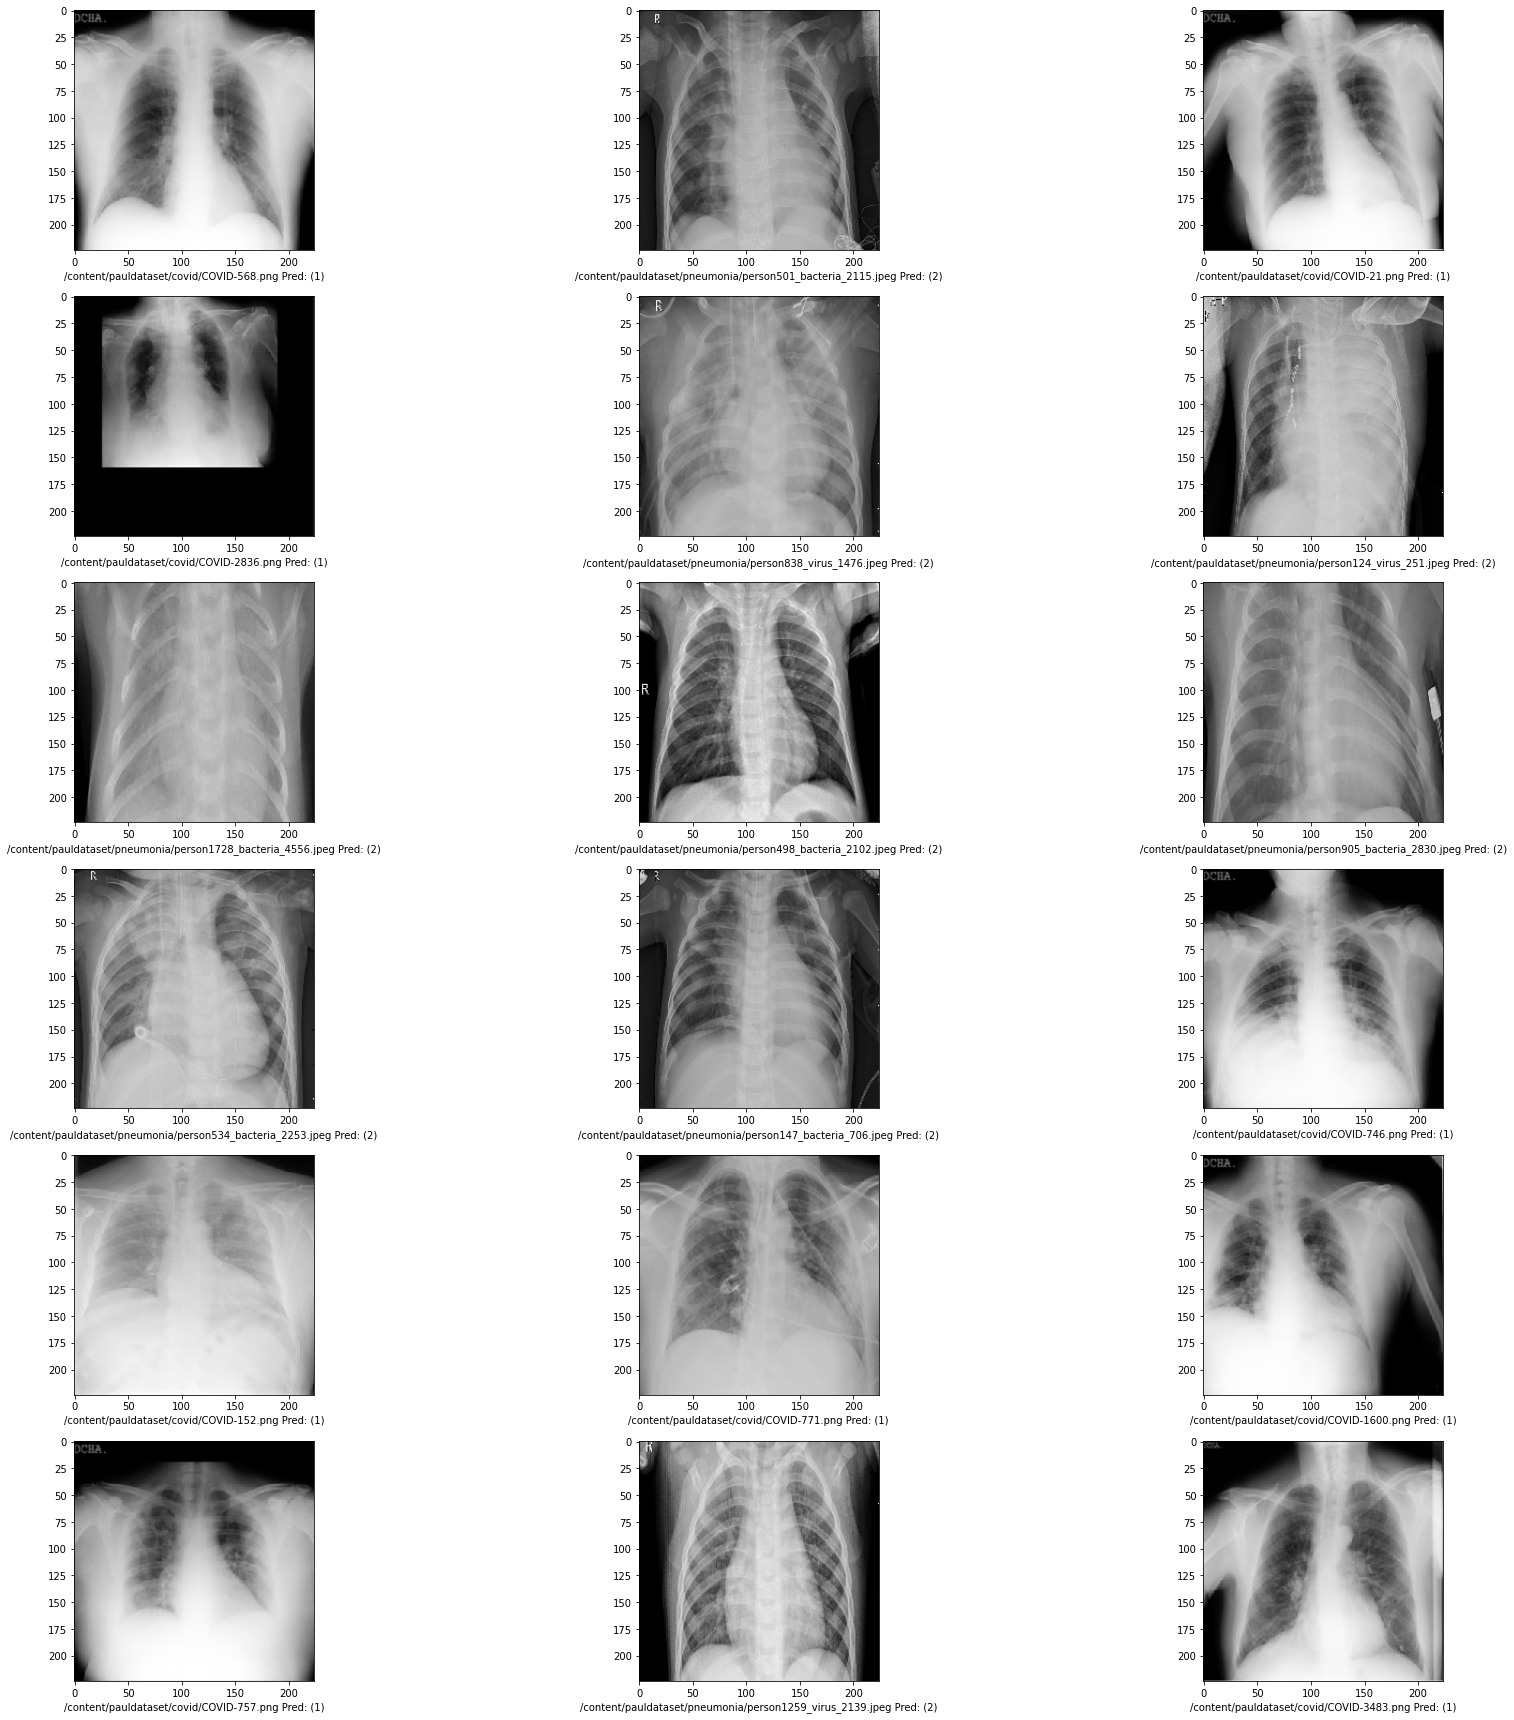

In [ ]:
plt.figure(figsize=(24, 24))

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    category = row['category']
    
    img = load_img (filename, target_size=IMAGE_SIZE)
    
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ' Pred: (' + "{}".format(category) + ')' )
    # break;
    
plt.tight_layout()
plt.show()

# Calculate Model Accuracy

In [ ]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['category']
    
    img = load_img( filename, target_size=IMAGE_SIZE)
    
    if 'normal' in filename:
        
        if prediction == 0:
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'covid' in filename:
        if prediction == 1: 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'pneumonia' in filename:
        
        if prediction == 2: 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1

In [ ]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
print('COVID-19 Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))

Model Accuracy: 98.05%
Correct Predictions: 1858 Total Predictions: 1895

Normal Predictions: 304 Accuracy 95.90%
COVID-19 Predictions: 722 Accuracy 99.86%
Viral Pneumonia Predictions: 832 Accuracy 97.31%


In [ ]:
actual = []
pred = []

for row in test_df.iterrows():
    
    filename = row[1][0]
    
    if 'normal' in filename: actual.append(0)
    if 'covid' in filename: actual.append(1)
    if 'pneumonia' in filename: actual.append(2)
        
    pred.append(row[1][1])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual, pred))  

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       317
           1       1.00      1.00      1.00       723
           2       0.98      0.97      0.98       855

    accuracy                           0.98      1895
   macro avg       0.97      0.98      0.97      1895
weighted avg       0.98      0.98      0.98      1895



In [ ]:
confusion_matrix(actual, pred)

array([[304,   0,  13],
       [  0, 722,   1],
       [ 21,   2, 832]])

# Predict single

In [ ]:
batch_size = 1
nb_samples = 1

In [ ]:
test_file = ["/content/pauldataset/normal/NORMAL2-IM-1203-0001.jpeg"]
df_file = pd.DataFrame({
    'filename': test_file
})

In [ ]:
df_file

,filename
0,/content/pauldataset/normal/NORMAL2-IM-1203-0001.jpeg


In [ ]:
test_single_gen = ImageDataGenerator(rescale = 1./127.5).flow_from_dataframe(
    df_file, 
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 1 validated image filenames.


In [ ]:
predict = loaded_model.predict(test_single_gen, steps = np.ceil(nb_samples/batch_size))

In [ ]:
df_file['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
df_file['category'] = df_file['category'].replace(label_map)

In [ ]:
# df_file['category'] = df_file['category'].replace({'Normal': 0, 'Covid': 1, 'Pneumonia': 2})

In [ ]:
df_file

,filename,category
0,/content/pauldataset/normal/NORMAL2-IM-1203-0001.jpeg,Normal
